# Heart Rate Analysis from ECG Data

This notebook demonstrates how to extract and analyze heart rate from ECG data using the SeizeIT2 dataset.
It includes seizure detection highlighting and heart rate variability analysis.

In [63]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import find_peaks, butter, filtfilt
import warnings
warnings.filterwarnings('ignore')

# Add Information/Data/seizeit2-main to path
sys.path.append(os.path.join('..', 'Information', 'Data', 'seizeit2-main'))

from classes.data import Data
from classes.annotation import Annotation

## Heart Rate Extraction Functions

These functions extract heart rate from raw ECG signals using R-peak detection.

In [64]:
def preprocess_ecg(ecg_signal, fs, lowcut=0.5, highcut=40):
    """
    Preprocesses ECG signal with bandpass filtering
    
    Args:
        ecg_signal (array): Raw ECG signal
        fs (int): Sampling frequency
        lowcut (float): Low cutoff frequency
        highcut (float): High cutoff frequency
    
    Returns:
        array: Filtered ECG signal
    """
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Bandpass filter
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, ecg_signal)
    
    return filtered_signal

def detect_r_peaks(ecg_signal, fs, min_distance_ms=400):
    """
    Detects R-peaks in ECG signal
    
    Args:
        ecg_signal (array): Preprocessed ECG signal
        fs (int): Sampling frequency
        min_distance_ms (int): Minimum distance between R-peaks in milliseconds
    
    Returns:
        array: Indices of R-peaks
    """
    # Minimum distance in samples
    min_distance = int(min_distance_ms * fs / 1000)
    
    # Find peaks with adaptive threshold
    # Use a threshold based on signal statistics
    threshold = np.std(ecg_signal) * 0.3
    
    peaks, properties = find_peaks(
        ecg_signal,
        height=threshold,
        distance=min_distance,
        prominence=threshold * 0.5
    )
    
    return peaks

def calculate_heart_rate(r_peaks, fs, window_size_sec=10, overlap_sec=5):
    """
    Calculates heart rate from R-peaks using sliding window
    
    Args:
        r_peaks (array): R-peak indices
        fs (int): Sampling frequency
        window_size_sec (int): Window size in seconds
        overlap_sec (int): Overlap between windows in seconds
    
    Returns:
        tuple: (time_points, heart_rates)
    """
    if len(r_peaks) < 2:
        return np.array([]), np.array([])
    
    # Convert R-peaks to time
    r_peak_times = r_peaks / fs
    
    # Create time windows
    total_time = r_peak_times[-1]
    step_size = window_size_sec - overlap_sec
    
    time_points = []
    heart_rates = []
    
    current_time = window_size_sec / 2  # Start from middle of first window
    
    while current_time + window_size_sec / 2 <= total_time:
        # Define window boundaries
        window_start = current_time - window_size_sec / 2
        window_end = current_time + window_size_sec / 2
        
        # Find R-peaks in this window
        window_peaks = r_peak_times[
            (r_peak_times >= window_start) & (r_peak_times <= window_end)
        ]
        
        if len(window_peaks) >= 2:
            # Calculate RR intervals in this window
            rr_intervals = np.diff(window_peaks)
            
            # Calculate mean heart rate (beats per minute)
            mean_rr = np.mean(rr_intervals)
            hr = 60 / mean_rr
            
            time_points.append(current_time)
            heart_rates.append(hr)
        
        current_time += step_size
    
    return np.array(time_points), np.array(heart_rates)

def extract_heart_rate_from_ecg(ecg_signal, fs):
    """
    Complete pipeline to extract heart rate from ECG signal
    
    Args:
        ecg_signal (array): Raw ECG signal
        fs (int): Sampling frequency
    
    Returns:
        dict: Dictionary containing processed data
    """
    # Preprocess ECG
    filtered_ecg = preprocess_ecg(ecg_signal, fs)
    
    # Detect R-peaks
    r_peaks = detect_r_peaks(filtered_ecg, fs)
    
    # Calculate heart rate
    hr_time, hr_values = calculate_heart_rate(r_peaks, fs)
    
    # Calculate RR intervals for HRV analysis
    rr_intervals = []
    rr_times = []
    if len(r_peaks) >= 2:
        rr_intervals = np.diff(r_peaks) / fs  # RR intervals in seconds
        rr_times = r_peaks[1:] / fs  # Time points for RR intervals
    
    return {
        'filtered_ecg': filtered_ecg,
        'r_peaks': r_peaks,
        'hr_time': hr_time,
        'hr_values': hr_values,
        'rr_intervals': rr_intervals,
        'rr_times': rr_times,
        'fs': fs
    }

## Heart Rate Plotting Functions

Functions to visualize heart rate data with seizure annotations.

In [65]:
def plot_heart_rate_with_seizures(data_path, patient_id='sub-001', duration_minutes=10):
    """
    Plots heart rate extracted from ECG with seizure markings
    
    Args:
        data_path (str): Path to dataset
        patient_id (str): Patient ID
        duration_minutes (int): Duration to plot in minutes
    """
    data_path = Path(data_path)
    
    # Find ECG files
    patient_path = data_path / patient_id / 'ses-01' / 'ecg'
    if not patient_path.exists():
        print(f"Error: ECG data for {patient_id} not found!")
        return
    
    ecg_files = list(patient_path.glob("*.edf"))
    if not ecg_files:
        print(f"No ECG files found for {patient_id}!")
        return
    
    # Extract run info
    first_file = ecg_files[0]
    run_info = first_file.name.split('_')[-2]
    
    print(f"Loading data for {patient_id}, {run_info}")
    
    # Load ECG data
    recording = [patient_id, run_info]
    data = Data.loadData(data_path.as_posix(), recording, modalities=['ecg'])
    
    if not data.data:
        print("No ECG data loaded!")
        return
    
    # Load annotations
    annotations = None
    try:
        annotations = Annotation.loadAnnotation(data_path.as_posix(), recording)
        print(f"Annotations loaded: {len(annotations.events)} seizure events found")
    except Exception as e:
        print(f"Warning: Could not load annotations: {e}")
    
    # Extract ECG signal
    ecg_signal = data.data[0]
    fs = data.fs[0]
    channel_name = data.channels[0] if data.channels else 'ECG'
    
    # Limit duration
    max_samples = int(duration_minutes * 60 * fs)
    if max_samples < len(ecg_signal):
        ecg_signal = ecg_signal[:max_samples]
        plot_duration = duration_minutes * 60
    else:
        plot_duration = len(ecg_signal) / fs
    
    print(f"Extracting heart rate from {len(ecg_signal)} samples...")
    
    # Extract heart rate
    hr_data = extract_heart_rate_from_ecg(ecg_signal, fs)
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Raw ECG (first 30 seconds for reference)
    ecg_time = np.linspace(0, min(30, plot_duration), min(int(30 * fs), len(ecg_signal)))
    ecg_sample = ecg_signal[:len(ecg_time)]
    
    ax1.plot(ecg_time, ecg_sample, 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_title(f'Raw ECG Signal (first 30s) - {patient_id} {run_info} - {channel_name}')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Heart Rate
    if len(hr_data['hr_time']) > 0:
        ax2.plot(hr_data['hr_time'], hr_data['hr_values'], 'r-', linewidth=2, label='Heart Rate')
        ax2.fill_between(hr_data['hr_time'], hr_data['hr_values'], alpha=0.3, color='red')
        
        # Add normal HR range
        ax2.axhspan(60, 100, alpha=0.1, color='green', label='Normal HR Range')
        
        # Mark seizures on heart rate plot
        seizure_count = 0
        if annotations and annotations.events:
            for i, (start_time, end_time) in enumerate(annotations.events):
                if start_time < plot_duration:
                    visible_end = min(end_time, plot_duration)
                    ax2.axvspan(start_time, visible_end, alpha=0.3, color='orange', 
                               label='Seizure' if i == 0 else "")
                    seizure_count += 1
        
        ax2.set_title('Heart Rate with Seizure Markings')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Heart Rate (BPM)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Statistics
        mean_hr = np.mean(hr_data['hr_values'])
        std_hr = np.std(hr_data['hr_values'])
        min_hr = np.min(hr_data['hr_values'])
        max_hr = np.max(hr_data['hr_values'])
        
        stats_text = f'Mean HR: {mean_hr:.1f} BPM\nStd: {std_hr:.1f}\nRange: {min_hr:.1f}-{max_hr:.1f}'
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'No heart rate data available', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=16)
        ax2.set_title('Heart Rate - No Data Available')
    
    # Plot 3: RR Intervals (Heart Rate Variability)
    if len(hr_data['rr_intervals']) > 0:
        rr_intervals_ms = hr_data['rr_intervals'] * 1000  # Convert to milliseconds
        ax3.plot(hr_data['rr_times'], rr_intervals_ms, 'g-', linewidth=1, alpha=0.7)
        ax3.scatter(hr_data['rr_times'], rr_intervals_ms, s=10, alpha=0.6, color='green')
        
        # Mark seizures on RR interval plot
        if annotations and annotations.events:
            for i, (start_time, end_time) in enumerate(annotations.events):
                if start_time < plot_duration:
                    visible_end = min(end_time, plot_duration)
                    ax3.axvspan(start_time, visible_end, alpha=0.3, color='orange')
        
        ax3.set_title('RR Intervals (Heart Rate Variability)')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('RR Interval (ms)')
        ax3.grid(True, alpha=0.3)
        
        # HRV Statistics
        mean_rr = np.mean(rr_intervals_ms)
        std_rr = np.std(rr_intervals_ms)
        rmssd = np.sqrt(np.mean(np.diff(rr_intervals_ms) ** 2))  # RMSSD
        
        hrv_text = f'Mean RR: {mean_rr:.1f} ms\nSDNN: {std_rr:.1f} ms\nRMSSD: {rmssd:.1f} ms'
        ax3.text(0.02, 0.98, hrv_text, transform=ax3.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    else:
        ax3.text(0.5, 0.5, 'No RR interval data available', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=16)
        ax3.set_title('RR Intervals - No Data Available')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nHeart Rate Analysis Summary:")
    print(f"  - Patient: {patient_id} {run_info}")
    print(f"  - Duration: {plot_duration:.1f} seconds")
    print(f"  - R-peaks detected: {len(hr_data['r_peaks'])}")
    if len(hr_data['hr_values']) > 0:
        print(f"  - Mean heart rate: {np.mean(hr_data['hr_values']):.1f} BPM")
        print(f"  - Heart rate range: {np.min(hr_data['hr_values']):.1f} - {np.max(hr_data['hr_values']):.1f} BPM")
    
    if annotations and annotations.events:
        print(f"\nSeizure Information:")
        for i, (start, end) in enumerate(annotations.events):
            if start < plot_duration:
                seizure_type = annotations.types[i] if i < len(annotations.types) else 'unknown'
                duration = end - start
                print(f"  - Seizure {i+1}: {start:.1f}s - {end:.1f}s ({duration:.1f}s, Type: {seizure_type})")
    
    return hr_data, annotations

## Configuration

Set the dataset path and analysis parameters.

In [66]:
# Dataset path
dataset_path = "../ds005873-download"

print("Heart Rate Analysis Script for SeizeIT2 Dataset")
print("=" * 50)
print(f"Dataset Path: {dataset_path}")
print()

Heart Rate Analysis Script for SeizeIT2 Dataset
Dataset Path: ../ds005873-download



## Find Patients with Seizures

First, let's find patients that have seizure annotations for heart rate analysis.

In [67]:
def find_patients_with_seizures(data_path, max_patients=10):
    """
    Finds patients with seizure annotations
    
    Args:
        data_path (str): Path to dataset
        max_patients (int): Maximum number of patients to check
    
    Returns:
        list: List of (patient_id, run_id, seizure_count) tuples
    """
    data_path = Path(data_path)
    patients_with_seizures = []
    
    # Find all patient directories
    patient_dirs = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('sub-')])
    
    print(f"Checking {min(max_patients, len(patient_dirs))} patients for seizure annotations...")
    
    for i, patient_dir in enumerate(patient_dirs[:max_patients]):
        patient_id = patient_dir.name
        
        # Look for ECG files
        ecg_path = patient_dir / 'ses-01' / 'ecg'
        if not ecg_path.exists():
            continue
            
        ecg_files = list(ecg_path.glob("*.edf"))
        for ecg_file in ecg_files:
            # Extract run info
            run_info = ecg_file.name.split('_')[-2]
            
            try:
                # Try to load annotations
                recording = [patient_id, run_info]
                annotations = Annotation.loadAnnotation(data_path.as_posix(), recording)
                
                if annotations.events and len(annotations.events) > 0:
                    patients_with_seizures.append((patient_id, run_info, len(annotations.events)))
                    print(f"✓ {patient_id} {run_info}: {len(annotations.events)} seizures")
                    
            except Exception as e:
                continue  # No annotations available
    
    return patients_with_seizures

# Find patients with seizures
seizure_patients = find_patients_with_seizures(dataset_path, max_patients=10)

print(f"\nFound {len(seizure_patients)} recordings with seizures")

Checking 10 patients for seizure annotations...
✓ sub-001 run-03: 1 seizures
✓ sub-001 run-05: 1 seizures
✓ sub-001 run-07: 1 seizures
✓ sub-001 run-08: 1 seizures
✓ sub-002 run-01: 2 seizures
✓ sub-002 run-02: 2 seizures
✓ sub-002 run-03: 1 seizures
✓ sub-002 run-05: 2 seizures
✓ sub-002 run-06: 3 seizures
✓ sub-002 run-09: 4 seizures
✓ sub-002 run-10: 1 seizures
✓ sub-003 run-06: 1 seizures
✓ sub-004 run-01: 4 seizures
✓ sub-005 run-22: 1 seizures
✓ sub-005 run-23: 1 seizures
✓ sub-006 run-01: 1 seizures
✓ sub-007 run-03: 2 seizures
✓ sub-008 run-01: 1 seizures
✓ sub-008 run-09: 1 seizures
✓ sub-009 run-09: 1 seizures
✓ sub-010 run-08: 1 seizures

Found 21 recordings with seizures


## Heart Rate Analysis with Seizure Markings

Now let's analyze heart rate data for patients with seizures.

\nComparing heart rate patterns across DIFFERENT patients with adaptive seizure windows:

Analyzing Patient sub-001 (run run-03, 1 seizures)...
  Adjusting window to 968.5 minutes to include seizure at 57975.0s
  Seizure 1: 57975.0s - 58047.0s (sz_foc_ia_nm)
  Window duration: 968.5 min, Seizures visible: 1

Analyzing Patient sub-002 (run run-09, 4 seizures)...
  Adjusting window to 281.8 minutes to include seizure at 16790.0s
  Seizure 1: 16790.0s - 16849.0s (sz_foc_ia_m_hyperkinetic)
  Window duration: 281.8 min, Seizures visible: 1

Analyzing Patient sub-003 (run run-06, 1 seizures)...
  Adjusting window to 546.8 minutes to include seizure at 32694.0s
  Seizure 1: 32694.0s - 32749.0s (sz_foc_ia_m_hyperkinetic)
  Window duration: 546.8 min, Seizures visible: 1

Analyzing Patient sub-004 (run run-01, 4 seizures)...
  Adjusting window to 24.4 minutes to include seizure at 1359.0s
  Seizure 1: 1359.0s - 1401.0s (sz_foc_a_nm)
  Window duration: 24.4 min, Seizures visible: 1

Analyzing Pa

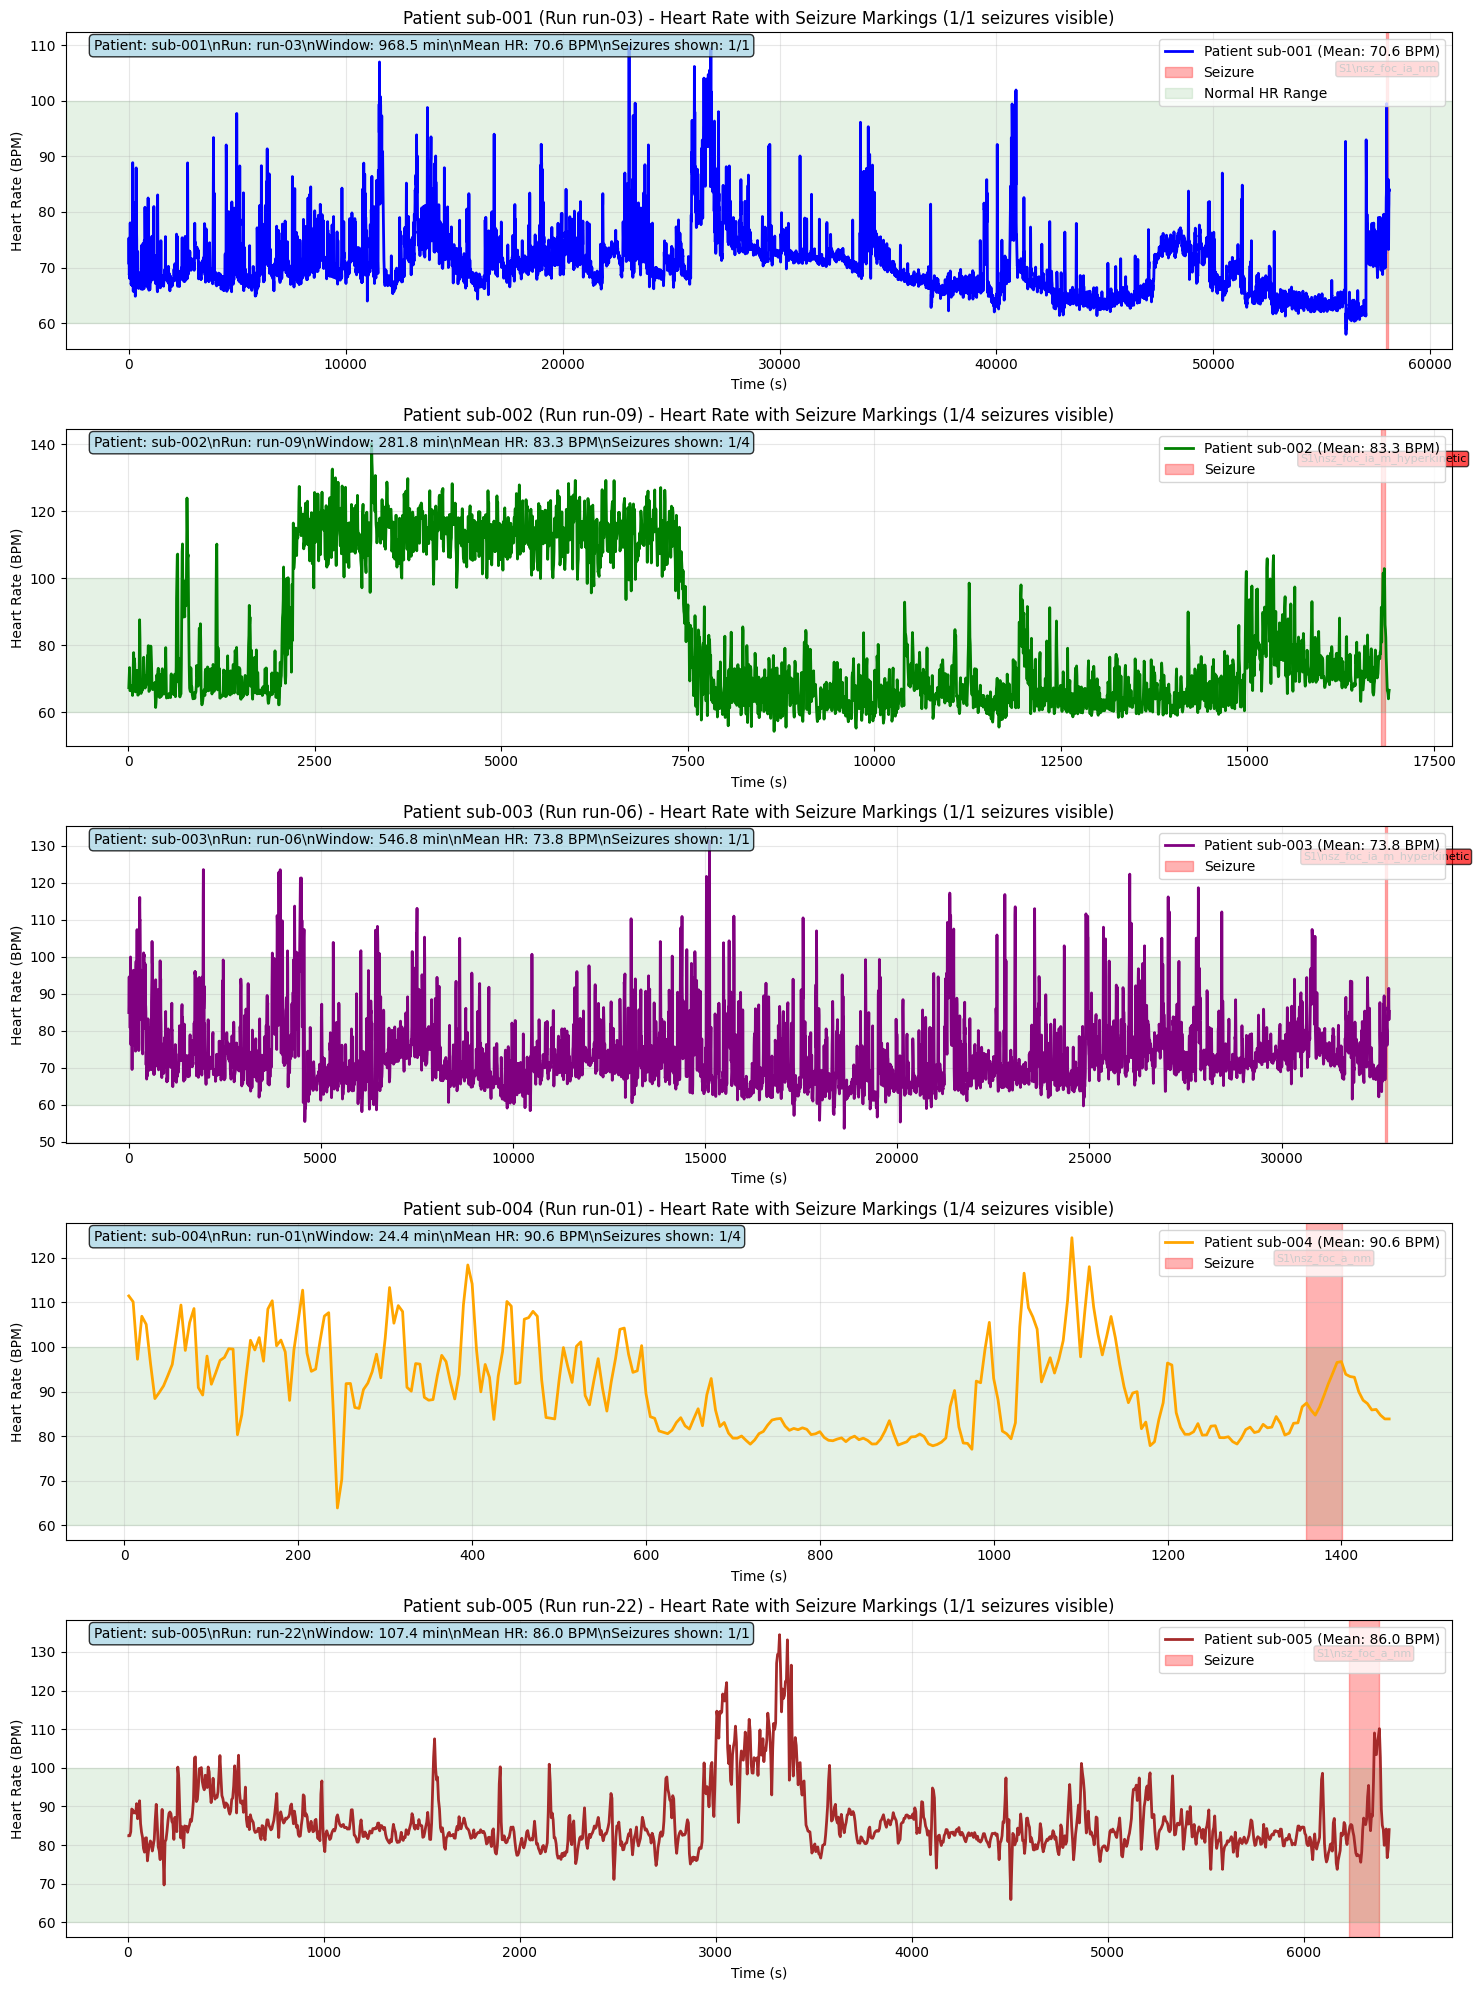

\nHeart Rate Comparison Summary (Unique Patients):
Patient ID | Run    | Duration | Mean HR  | Std    | Range        | Seizures
------------------------------------------------------------------------------------------
sub-001    | run-03 |  968.5m |   70.6   |   5.8 |  58.0-109.7 | 1/     1
sub-002    | run-09 |  281.8m |   83.3   |  22.0 |  54.3-140.1 | 1/     4
sub-003    | run-06 |  546.8m |   73.8   |   9.2 |  53.7-131.3 | 1/     1
sub-004    | run-01 |   24.4m |   90.6   |  10.4 |  63.9-124.5 | 1/     4
sub-005    | run-22 |  107.4m |   86.0   |   8.3 |  65.9-134.5 | 1/     1


In [68]:
def compare_patient_heart_rates(data_path, max_patients=3, min_duration_minutes=5):
    """
    Compares heart rate patterns across different PATIENTS (not runs)
    Automatically adjusts window size to include at least one seizure per patient
    
    Args:
        data_path (str): Path to dataset
        max_patients (int): Maximum number of different patients to compare
        min_duration_minutes (int): Minimum duration to analyze (will be extended if needed)
    """
    if len(seizure_patients) == 0:
        print("No patients with seizures found for comparison.")
        return
    
    # Group by unique patient IDs to ensure we compare different patients
    unique_patients = {}
    for patient_id, run_id, seizure_count in seizure_patients:
        if patient_id not in unique_patients:
            unique_patients[patient_id] = (patient_id, run_id, seizure_count)
        # If patient already exists, keep the run with more seizures
        elif seizure_count > unique_patients[patient_id][2]:
            unique_patients[patient_id] = (patient_id, run_id, seizure_count)
    
    # Convert back to list and limit to max_patients
    patients_to_compare = list(unique_patients.values())[:max_patients]
    
    if len(patients_to_compare) < max_patients:
        print(f"Warning: Only {len(patients_to_compare)} unique patients found with seizures.")
    
    fig, axes = plt.subplots(len(patients_to_compare), 1, figsize=(15, 4 * len(patients_to_compare)))
    if len(patients_to_compare) == 1:
        axes = [axes]
    
    hr_stats = []
    
    for i, (patient_id, run_id, seizure_count) in enumerate(patients_to_compare):
        print(f"\nAnalyzing Patient {patient_id} (run {run_id}, {seizure_count} seizures)...")
        
        # Load annotations first to determine optimal window size
        recording = [patient_id, run_id]
        annotations = Annotation.loadAnnotation(data_path, recording)
        
        # Calculate optimal duration to include at least one seizure
        if annotations.events:
            # Find the end time of the first seizure + some buffer
            first_seizure_end = annotations.events[0][1]  # end time of first seizure
            optimal_duration_sec = max(min_duration_minutes * 60, first_seizure_end + 60)  # +1 min buffer
            optimal_duration_minutes = optimal_duration_sec / 60
            print(f"  Adjusting window to {optimal_duration_minutes:.1f} minutes to include seizure at {annotations.events[0][0]:.1f}s")
        else:
            optimal_duration_minutes = min_duration_minutes
        
        # Load ECG data
        data = Data.loadData(data_path, recording, modalities=['ecg'])
        ecg_signal = data.data[0]
        fs = data.fs[0]
        
        # Limit duration to optimal size
        max_samples = int(optimal_duration_minutes * 60 * fs)
        if max_samples < len(ecg_signal):
            ecg_signal = ecg_signal[:max_samples]
            plot_duration = optimal_duration_minutes * 60
        else:
            plot_duration = len(ecg_signal) / fs
        
        # Extract heart rate
        hr_data = extract_heart_rate_from_ecg(ecg_signal, fs)
        
        if len(hr_data['hr_values']) > 0:
            # Plot heart rate - use different colors for each patient
            colors = ['blue', 'green', 'purple', 'orange', 'brown']
            color = colors[i % len(colors)]
            
            axes[i].plot(hr_data['hr_time'], hr_data['hr_values'], linewidth=2, color=color,
                        label=f'Patient {patient_id} (Mean: {np.mean(hr_data["hr_values"]):.1f} BPM)')
            
            # Mark seizures with color highlighting
            seizures_in_window = 0
            for j, (start_time, end_time) in enumerate(annotations.events):
                if start_time < plot_duration:
                    visible_end = min(end_time, plot_duration)
                    
                    # Color-highlight seizure regions
                    axes[i].axvspan(start_time, visible_end, alpha=0.3, color='red', 
                                   label='Seizure' if j == 0 else "")
                    
                    # Add seizure type annotation if available
                    seizure_type = annotations.types[j] if j < len(annotations.types) else 'unknown'
                    mid_time = (start_time + visible_end) / 2
                    
                    # Add text annotation for seizures
                    axes[i].text(mid_time, axes[i].get_ylim()[1] * 0.95, 
                               f'S{j+1}\\n{seizure_type}', 
                               ha='center', va='top', fontsize=8, 
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7))
                    
                    seizures_in_window += 1
                    print(f"  Seizure {j+1}: {start_time:.1f}s - {visible_end:.1f}s ({seizure_type})")
            
            # Add normal HR range for reference
            axes[i].axhspan(60, 100, alpha=0.1, color='green', 
                           label='Normal HR Range' if i == 0 else "")
            
            # Store statistics
            hr_stats.append({
                'patient_id': patient_id,
                'run_id': run_id,
                'duration_minutes': optimal_duration_minutes,
                'mean_hr': np.mean(hr_data['hr_values']),
                'std_hr': np.std(hr_data['hr_values']),
                'min_hr': np.min(hr_data['hr_values']),
                'max_hr': np.max(hr_data['hr_values']),
                'seizure_count_total': seizure_count,
                'seizures_in_window': seizures_in_window
            })
            
            print(f"  Window duration: {optimal_duration_minutes:.1f} min, Seizures visible: {seizures_in_window}")
        
        axes[i].set_title(f'Patient {patient_id} (Run {run_id}) - Heart Rate with Seizure Markings ({seizures_in_window}/{seizure_count} seizures visible)')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Heart Rate (BPM)')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(loc='upper right')
        
        # Add patient-specific info box
        info_text = f'Patient: {patient_id}\\nRun: {run_id}\\nWindow: {optimal_duration_minutes:.1f} min'
        if len(hr_data['hr_values']) > 0:
            info_text += f'\\nMean HR: {np.mean(hr_data["hr_values"]):.1f} BPM'
            info_text += f'\\nSeizures shown: {seizures_in_window}/{seizure_count}'
        axes[i].text(0.02, 0.98, info_text, transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\\nHeart Rate Comparison Summary (Unique Patients):")
    print("=" * 90)
    print(f"{'Patient ID':10} | {'Run':6} | {'Duration':8} | {'Mean HR':8} | {'Std':6} | {'Range':12} | {'Seizures':8}")
    print("-" * 90)
    for stats in hr_stats:
        print(f"{stats['patient_id']:10} | {stats['run_id']:6} | {stats['duration_minutes']:6.1f}m | "
              f"{stats['mean_hr']:6.1f}   | {stats['std_hr']:5.1f} | "
              f"{stats['min_hr']:5.1f}-{stats['max_hr']:5.1f} | "
              f"{stats['seizures_in_window']}/{stats['seizure_count_total']:6}")

# Compare heart rates across DIFFERENT patients with adaptive window sizes
if len(seizure_patients) > 0:
    print("\\nComparing heart rate patterns across DIFFERENT patients with adaptive seizure windows:")
    compare_patient_heart_rates(dataset_path, max_patients=min(5, len(seizure_patients)), min_duration_minutes=5)

## Heart Rate Variability Analysis

Let's create a detailed analysis of heart rate variability around seizure events.


Detailed HRV analysis around seizures for sub-001 run-05:

Analyzing Seizure 1: 60968.0s - 61049.0s (sz_foc_a_nm)


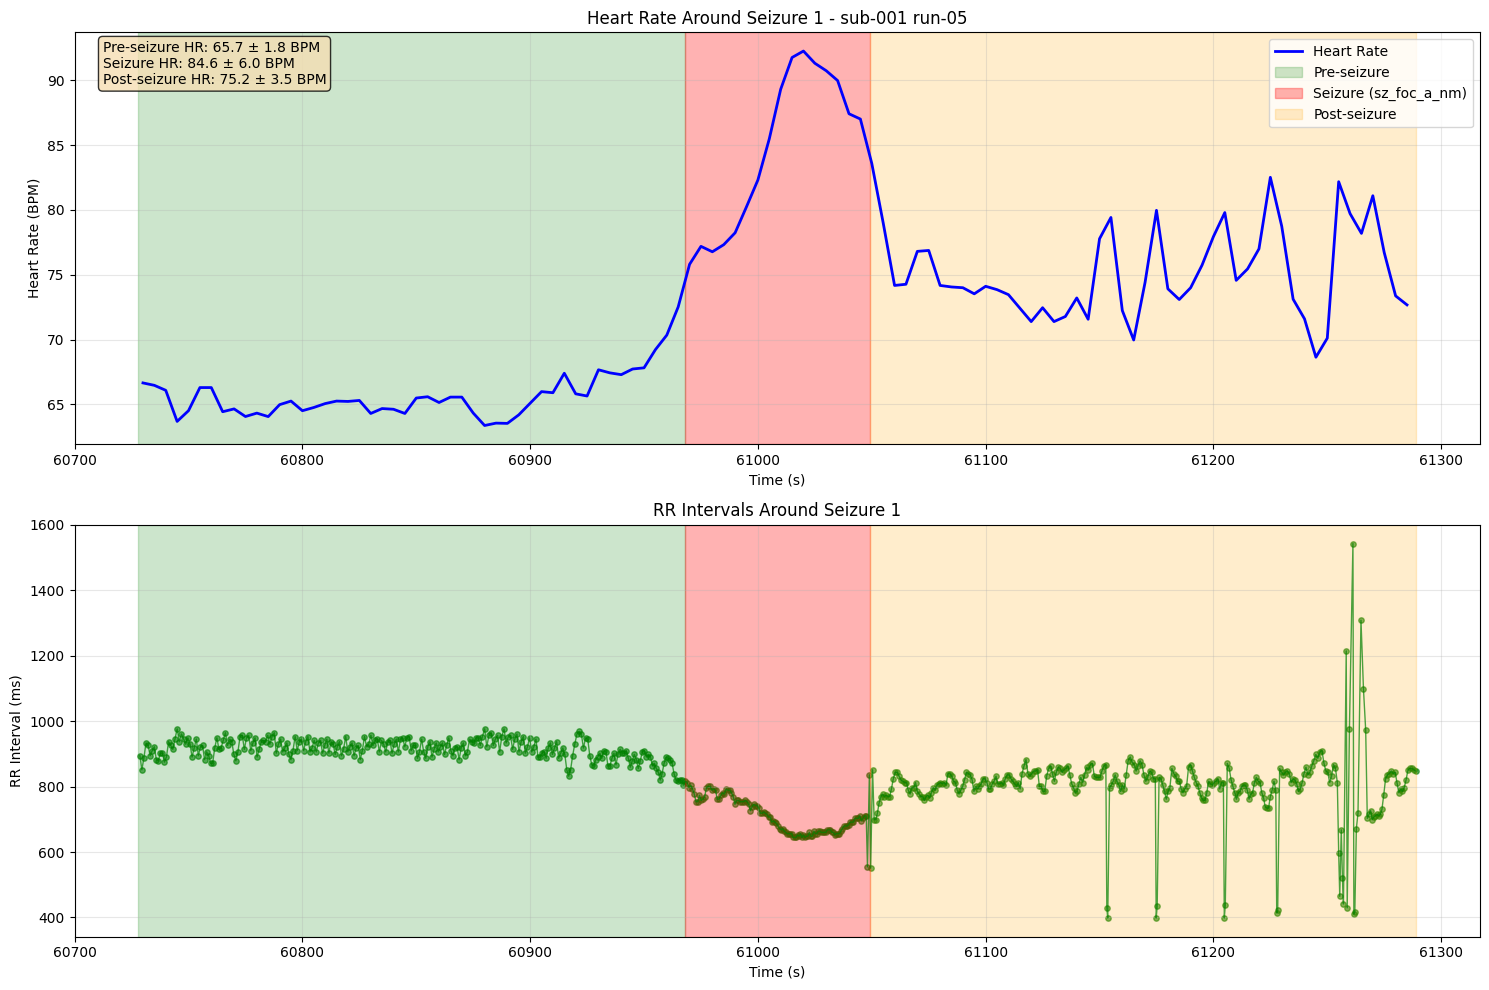

In [69]:
def analyze_hrv_around_seizures(data_path, patient_id, run_id, pre_seizure_min=2, post_seizure_min=2):
    """
    Analyzes heart rate variability around seizure events
    
    Args:
        data_path (str): Path to dataset
        patient_id (str): Patient ID
        run_id (str): Run ID
        pre_seizure_min (int): Minutes before seizure to analyze
        post_seizure_min (int): Minutes after seizure to analyze
    """
    # Load data
    recording = [patient_id, run_id]
    data = Data.loadData(data_path, recording, modalities=['ecg'])
    annotations = Annotation.loadAnnotation(data_path, recording)
    
    if not annotations.events:
        print("No seizure events found!")
        return
    
    # Extract heart rate for entire recording
    ecg_signal = data.data[0]
    fs = data.fs[0]
    hr_data = extract_heart_rate_from_ecg(ecg_signal, fs)
    
    # Analyze each seizure
    for i, (seizure_start, seizure_end) in enumerate(annotations.events):
        seizure_type = annotations.types[i] if i < len(annotations.types) else 'unknown'
        
        print(f"\nAnalyzing Seizure {i+1}: {seizure_start:.1f}s - {seizure_end:.1f}s ({seizure_type})")
        
        # Define analysis windows
        pre_start = max(0, seizure_start - pre_seizure_min * 60)
        post_end = min(len(ecg_signal)/fs, seizure_end + post_seizure_min * 60)
        
        # Create figure for this seizure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot heart rate around seizure
        hr_mask = (hr_data['hr_time'] >= pre_start) & (hr_data['hr_time'] <= post_end)
        if np.any(hr_mask):
            hr_time_window = hr_data['hr_time'][hr_mask]
            hr_values_window = hr_data['hr_values'][hr_mask]
            
            ax1.plot(hr_time_window, hr_values_window, 'b-', linewidth=2, label='Heart Rate')
            
            # Mark different phases
            ax1.axvspan(pre_start, seizure_start, alpha=0.2, color='green', label='Pre-seizure')
            ax1.axvspan(seizure_start, seizure_end, alpha=0.3, color='red', label=f'Seizure ({seizure_type})')
            ax1.axvspan(seizure_end, post_end, alpha=0.2, color='orange', label='Post-seizure')
            
            # Calculate HR statistics for each phase
            pre_mask = (hr_time_window >= pre_start) & (hr_time_window < seizure_start)
            seizure_mask = (hr_time_window >= seizure_start) & (hr_time_window <= seizure_end)
            post_mask = (hr_time_window > seizure_end) & (hr_time_window <= post_end)
            
            stats_text = ""
            if np.any(pre_mask):
                pre_hr = hr_values_window[pre_mask]
                stats_text += f"Pre-seizure HR: {np.mean(pre_hr):.1f} ± {np.std(pre_hr):.1f} BPM\n"
            
            if np.any(seizure_mask):
                seizure_hr = hr_values_window[seizure_mask]
                stats_text += f"Seizure HR: {np.mean(seizure_hr):.1f} ± {np.std(seizure_hr):.1f} BPM\n"
            
            if np.any(post_mask):
                post_hr = hr_values_window[post_mask]
                stats_text += f"Post-seizure HR: {np.mean(post_hr):.1f} ± {np.std(post_hr):.1f} BPM"
            
            ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax1.set_title(f'Heart Rate Around Seizure {i+1} - {patient_id} {run_id}')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Heart Rate (BPM)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot RR intervals around seizure
        rr_mask = (hr_data['rr_times'] >= pre_start) & (hr_data['rr_times'] <= post_end)
        if np.any(rr_mask) and len(hr_data['rr_intervals']) > 0:
            rr_time_window = hr_data['rr_times'][rr_mask]
            rr_intervals_window = hr_data['rr_intervals'][rr_mask] * 1000  # Convert to ms
            
            ax2.plot(rr_time_window, rr_intervals_window, 'g-', linewidth=1, alpha=0.7)
            ax2.scatter(rr_time_window, rr_intervals_window, s=15, alpha=0.6, color='green')
            
            # Mark phases
            ax2.axvspan(pre_start, seizure_start, alpha=0.2, color='green')
            ax2.axvspan(seizure_start, seizure_end, alpha=0.3, color='red')
            ax2.axvspan(seizure_end, post_end, alpha=0.2, color='orange')
        
        ax2.set_title(f'RR Intervals Around Seizure {i+1}')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('RR Interval (ms)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Analyze HRV around seizures for the first patient with seizures
if seizure_patients:
    patient_id, run_id, seizure_count = seizure_patients[1]
    print(f"\nDetailed HRV analysis around seizures for {patient_id} {run_id}:")
    analyze_hrv_around_seizures(dataset_path, patient_id, run_id, pre_seizure_min=4, post_seizure_min=4)

## Summary and Export

Summary of the heart rate analysis and potential data export functionality.

In [71]:
print("Heart Rate Analysis Complete!")
print("=" * 50)
print("\nThis notebook demonstrated:")
print("✓ ECG preprocessing and R-peak detection")
print("✓ Heart rate extraction using sliding window analysis")
print("✓ Heart rate variability (HRV) analysis")
print("✓ Seizure event marking on heart rate plots")
print("✓ Detailed analysis around seizure events")
print("✓ Comparison across multiple patients")
print("\nKey findings from this analysis can be used for:")
print("- Feature engineering for seizure detection algorithms")
print("- Understanding cardiovascular changes during seizures")
print("- Baseline heart rate variability assessment")
print("- Comparative analysis across patient populations")

Heart Rate Analysis Complete!

This notebook demonstrated:
✓ ECG preprocessing and R-peak detection
✓ Heart rate extraction using sliding window analysis
✓ Heart rate variability (HRV) analysis
✓ Seizure event marking on heart rate plots
✓ Detailed analysis around seizure events
✓ Comparison across multiple patients

Key findings from this analysis can be used for:
- Feature engineering for seizure detection algorithms
- Understanding cardiovascular changes during seizures
- Baseline heart rate variability assessment
- Comparative analysis across patient populations
